In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import analysis_utils as aute

In [2]:
rdm_th = 0
corr_th = 0.85

In [3]:
path_to_conversations = "../Conversations/"

all_df_list = []
for conv in os.listdir(path_to_conversations):
    excel_name = [file for file in os.listdir(path_to_conversations + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel(path_to_conversations + conv + "/" + excel_name)
    if df_x.shape[0] > 2:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

IndexError: list index out of range

In [4]:
check_list = []
for df in all_df_list:
    check_list.append({
        "NumRows": df.shape[0],
        "NumCols": df.shape[1],
        "TimeConversation_min": (df["UnixTimestampEnd"].iloc[-1] - df["UnixTimestampInit"].iloc[0])/60
    })
    
df_check = pd.DataFrame(check_list)

Mean Number of rows = 9.3448 +/- 6.1154 ; Median = 8.0 ; Min. =  3 ; Max. =  26



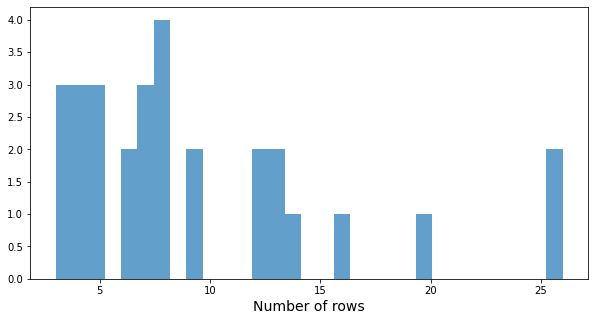

Mean Number of cols = 11.1034 +/- 0.9227 ; Median = 11.0 ; Min. =  10 ; Max. =  12

Mean Time conversation (min) = 1.376 +/- 1.0499 ; Median = 0.9108 ; Min. =  0.1873 ; Max. =  3.8995



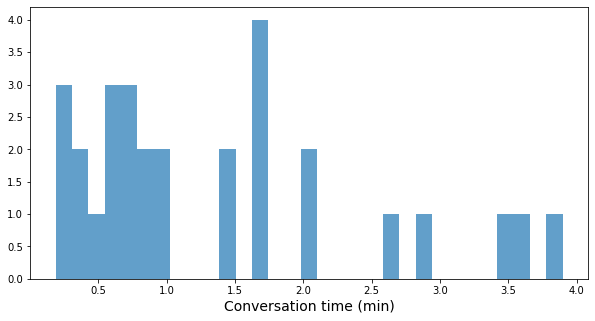

In [5]:
aute.stat_print(df_check["NumRows"], "Number of rows")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["NumRows"], bins=31, alpha=0.7)
plt.xlabel("Number of rows", fontsize=14)

plt.show()

aute.stat_print(df_check["NumCols"], "Number of cols")
print()

aute.stat_print(df_check["TimeConversation_min"], "Time conversation (min)")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["TimeConversation_min"], bins=31, alpha=0.7)
plt.xlabel("Conversation time (min)", fontsize=14)

plt.show()